## Exercises in Machine Learning

*Author*: Zach del Rosario

The _primary_ purpose of this notebook is to help you *not get fooled by machine learning*! As Drew Conway notes, possessing hacking skills and substantive experience---but having no math or statistics background---puts one in the [danger zone](http://drewconway.com/zia/2013/3/26/the-data-science-venn-diagram). While we can't possibly cover *everything* you need in a single workshop, this exercise will highlight some of the challenges of doing machine learning well. 

### Learning outcomes
By working through this notebook, you will be able to:

- Use grama to work with models.
- Understand the importance of *underfitting* and *overfitting*
- Use cross-validation to help avoid *underfitting* and *overfitting*

Tips:

- This exercise heavily uses the [py-grama](https://github.com/zdelrosario/py_grama) package; you can find more info on the [documentation site](https://py-grama.readthedocs.io/en/latest/).
- This exercise indirectly uses [scikit-learn](https://scikit-learn.org/stable/); you can find lots of useful info on this package on their [documentation site](https://scikit-learn.org/stable/documentation.html).


In [1]:
# Setup
import numpy as np
import pandas as pd
import plotnine as pt
import grama as gr

DF = gr.Intention()



In [2]:
# Helper functions
def add_noise(function, sigma=0.1, seed=101):
    """Add noise to deterministic functions
    """
    def new_function(x):
        np.random.seed(seed)
        y = function(x)
        return y + sigma * np.random.normal(size=y.shape)

    return new_function

# Reference points for regression examples
X_ref = np.linspace(-1, +1, num=100)

# Reference models
def fcn_1(x): return (0.3 * x**2 + 1.0 * x + 2)
def fcn_2(x): return (-2.0 * x**3 + 0.4 * x**2 + 1.0 * x + 2)

fcn_1_noisy = gr.make_symbolic(add_noise(fcn_1))
fcn_2_noisy = gr.make_symbolic(add_noise(fcn_2, sigma=0.2))

# Package as a dataframe
df_data = gr.df_make(
    x=X_ref,
    y_1=fcn_1_noisy(X_ref),
    y_2=fcn_2_noisy(X_ref),
)

## Helper Function

---

(This function will automate some steps so we can focus on high-level ideas, but I define it here in case you'd like to see the details)


In [3]:
## For partial evaluation
from toolz import curry
# Model training tools
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

## Encapsulate featurizer and regressor in one object
class FunctionLM(gr.Function):
    def __init__(self, regressor, var, out, name, order, runtime):
        self.regressor = regressor
        self.var = var
        self.out = list(map(lambda s: s + "_mean", out))
        self.name = name
        self.order = order
        self.runtime = runtime

    def eval(self, df):
        ## Check invariant; model inputs must be subset of df columns
        if not set(self.var).issubset(set(df.columns)):
            raise ValueError(
                "Model function `{}` var not a subset of given columns".format(
                    self.name
                )
            )

        ## Featurize
        x = np.atleast_2d(df[self.var].values)
        poly = PolynomialFeatures(self.order)
        X_feat = poly.fit_transform(x)
        
        ## Predict
        y = self.regressor.predict(X_feat).flatten()
        return pd.DataFrame(data=y, columns=self.out)

## Fitting routine
@curry
def fit_regression(df, var=None, out=None, order=1):
    r"""Fit a linear regression of specified order
    
    Args:
        df (DataFrame): Data for fitting
        var (iterable of str): Names of input variable (feature); must be column in df
        out (iterable of str): Name of output variable (response); must be column in df
        order (int): Polynomial order for fit
    
    """
    if len(out) > 1:
        raise ValueError("This simple helper")
    # Featurize
    x = np.atleast_2d(df[var].values)
    poly = PolynomialFeatures(order)
    X_feat = poly.fit_transform(x)
    
    # Fit regression
    y = np.atleast_2d(df[out].values)
    lm = LinearRegression()
    lm.fit(X_feat, y)
    
    # Package
    fun = FunctionLM(lm, var, out, "Linear Model", order, 0)
    
    return gr.Model(functions=[fun], domain=None, density=None)
    
## Create pipe-enabled regression utility
ft_regression = gr.add_pipe(fit_regression)


## Underfitting and Overfitting

---

First we'll cover some key ideas on simple cases. These are not 'real' data, but the simplicity of the examples will allow us to focus on concepts.

Here I generate some data from a simple polynomial.

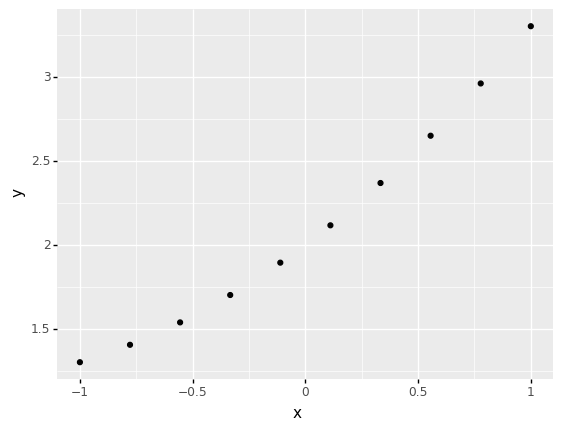

<ggplot: (8744263793643)>

In [4]:
## NOTE: No need to edit
# Ground-truth data; no noise
df_ex1 = (
    gr.df_make(x=np.linspace(-1, +1, num=10))
    >> gr.tf_mutate(y=fcn_1(DF.x))
)

# Plot
(
    df_ex1
    >> pt.ggplot(pt.aes("x", "y"))
    + pt.geom_point()
)

We will fit a simple [linear regression](https://en.wikipedia.org/wiki/Linear_regression) to these data. To do this, we'll use the linear regression helper `ft_regression()` (defined above). To start, we'll assume that the data were generated from an underlying rule (a _model_) of the form

$$y_{\text{mean}} = m x + b,$$

and attempt to _learn_ the slope $m$ and intercept $b$ by _minimizing_ the difference between the measured values `y` and the predicted values `y_mean`.


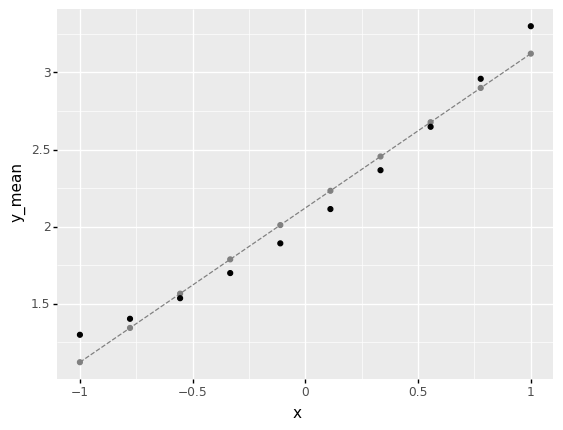

<ggplot: (8744263793508)>

In [5]:
## NOTE: No need to edit
# Fit the line
md_line = (
    df_ex1
    >> ft_regression(var=["x"], out=["y"], order=1)
)

# Predict
df_line_pred = (
    md_line
    >> gr.ev_df(df=df_ex1)
)

# Plot results
(
    df_line_pred
    >> pt.ggplot(pt.aes("x", "y_mean"))
    + pt.geom_line(linetype="dashed", color="grey")
    + pt.geom_point(color="grey")
    + pt.geom_point(pt.aes(y="y"))
)

### Working with models in Grama

(TODO A grama model encapsulates a lot of information)


In [6]:
## NOTE: No need to edit, run to show info on `md_line`
md_line


model: None

  inputs:
    var_det:
      x: (unbounded)

    var_rand:


    copula:
      None

  functions:
      Linear Model: ['x'] -> ['y_mean']

Based on this summary of the model, we can see that it takes a single input `x` and maps it to a single output `y_mean`.


### __QX__: Evaluate the model at new input values

Use the function `gr.ev_df()` to evaluate the model `md_line` fitted above. Make use of the new set of input values `df_dense`. Answer the questions below.


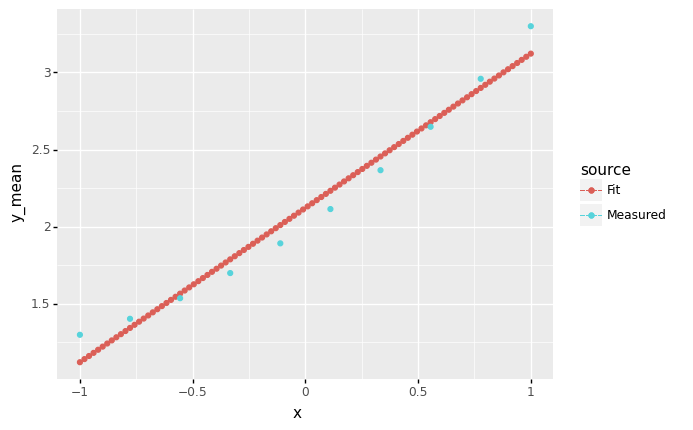

<ggplot: (8744245620011)>

In [7]:
###
# TASK: Evaluate md_line at the df_dense input values.
###

# -- FINISH THE CODE BELOW -----
df_dense = gr.df_make(x=np.linspace(-1, +1, num=100))

df_evaluated = (
    md_line
# task-begin
## TODO: Evaluate the model here
# task-end
# solution-begin
    >> gr.ev_df(df=df_dense)
# solution-end
)

# -- NO NEED TO EDIT BELOW HERE -----
(
    df_evaluated
    >> gr.tf_mutate(source="Fit")
    >> pt.ggplot(pt.aes("x", "y_mean", color="source"))
    + pt.geom_line(linetype="dashed")
    + pt.geom_point()
    + pt.geom_point(
        data=df_ex1
        >> gr.tf_mutate(source="Measured"),
        mapping=pt.aes(y="y"),
    )
)

*Observe*

- How many points are measured? How many are fit? (Note: Don't count by hand, try looking at the code!)
<!-- task-begin -->
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
  - There are 10 measured points, while there are 100 evaluated via the fit.
<!-- solution-end -->
- Suppose we wanted to evaluate the quality of our fit. At how many locations could we evaluate the quality of the fit? Why?
<!-- task-begin -->
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
  - We could only evaluate the quality of the fit at 10 locations; the same ones where we have measurements of the function value.
<!-- solution-end -->


### Model Flexibility and _Underfitting_

Note that we had to _assume_ a model-form in order to do the fitting. From the figure above, we can see that the model is close to the true values, but obviously lacks the curvature of the true data-generating process.

This phenomenon---the failure of a model to capture behavior in the data---is called _underfitting_. To reduce underfitting, we need to make our model _more flexible_. For a linear regression, we can do this by **increasing the order** of the regression.


### __QX__: Fit a quadratic model to the data

Use the `ft_regression()` helper to fit a quadratic model (`order = 2`).


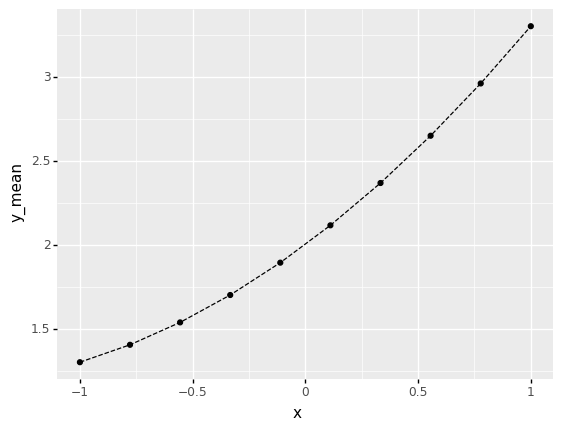

<ggplot: (8744245609855)>

In [8]:
###
# TASK: Fit a quadratic model
###

# -- FINISH THE CODE BELOW -----
# Fit a quadratic
md_quad = (
    df_ex1
# task-begin
## TODO: Fit a regression here
# task-end
# solution-begin
    >> ft_regression(var=["x"], out=["y"], order=2)
# solution-end
)

# -- NO NEED TO EDIT BELOW HERE -----
# Predict
df_quad_pred = (
    md_quad
    >> gr.ev_df(df=df_ex1)
)

# Plot results
(
    df_quad_pred
    >> pt.ggplot(pt.aes("x", "y_mean"))
    + pt.geom_line(linetype="dashed")
    + pt.geom_point(pt.aes(y="y"))
)

Here we can see the model fits the data _perfectly_. This _suggests_ that we have successfully discovered the _exact_ rule that generated these data, which in _this special case happens to be true_.

However, we will very rarely be able to fit the true function exactly. This is because real data tend to have _noise_, which corrupts the underlying function we are trying to learn.

### Noise and _Overfitting_

Below, I generate data from the same model, but add a little bit of noise.

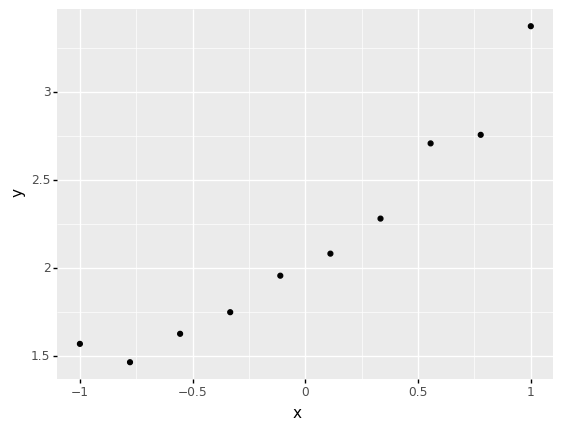

<ggplot: (8744263824427)>

In [9]:
## NOTE: No need to edit
# Ground-truth data; now with noise
df_ex2 = (
    gr.df_make(x=np.linspace(-1, +1, num=10))
    >> gr.tf_mutate(y=fcn_1_noisy(DF.x))
)

# Plot
(
    df_ex2
    >> pt.ggplot(pt.aes("x", "y"))
    + pt.geom_point()
)

Let's see what happens when we fit a quadratic to the noisy data.


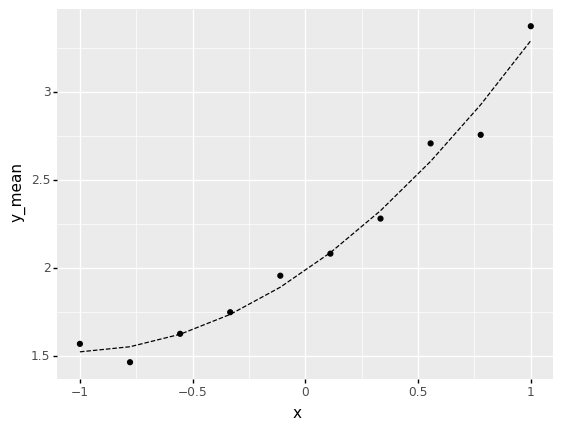

<ggplot: (8744245588896)>

In [10]:
## NOTE: No need to edit
(
    df_ex2
    >> ft_regression(var=["x"], out=["y"], order=2)
    >> gr.ev_df(df=df_ex2)
    
    >> pt.ggplot(pt.aes("x", "y_mean"))
    + pt.geom_line(linetype="dashed")
    + pt.geom_point(pt.aes(y="y"))
)

Here we can see that the fit is no longer perfect, despite coming from the "same" model. Since we already know that a quadratic can fit the underlying function perfectly, underfitting is not the issue here. Instead, the error is increased due to the noise in the data.

_However_, we have not yet seen a case of _overfitting_. To see that phenomenon, let's keep increasing the order of the model.

### __QX__: Overfit the model

Increase the `order` of the regression until the model goes through every measured point. Does this seem like a reasonable model?


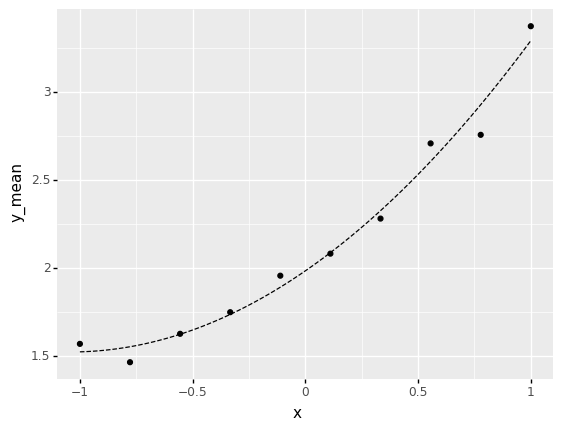

<ggplot: (8744245563986)>

In [11]:
###
# TASK: Increase the order until the fit is perfect
###

# -- FINISH THE CODE BELOW -----
(
    df_ex2
    >> ft_regression(
        var=["x"], 
        out=["y"], 
        order=2 # TODO: Increase the order until the fit is perfect
    )
    >> gr.ev_df(df=gr.df_make(x=np.linspace(-1, +1, num=100)))
    
    >> pt.ggplot(pt.aes("x", "y_mean"))
    + pt.geom_line(linetype="dashed")
    + pt.geom_point(
        data=df_ex2,
        mapping=pt.aes(y="y"),
    )
)

To help illustrate, let's look at one more synthetic example

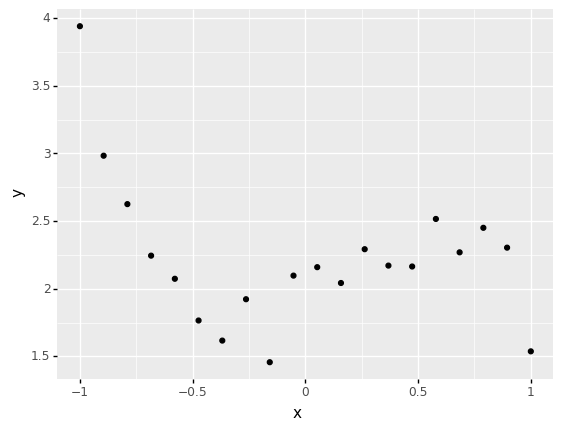

<ggplot: (8744245572886)>

In [12]:
## NOTE: No need to edit
# More complicated function with noise
df_ex3 = (
    gr.df_make(x=np.linspace(-1, +1, num=20))
    >> gr.tf_mutate(y=fcn_2_noisy(DF.x))
)

(
    df_ex3
    >> pt.ggplot(pt.aes("x", "y"))
    + pt.geom_point()
)

Here we can see a somewhat complicated function that is quite corrupted by noise. Below, I'm going to fit a number of polynomial models of different orders. In practice, we would like to _make a decision_ about what polynomial order to use. A sensible choice would be to pick the order that minimizes the error---let's see which model accomplishes this.


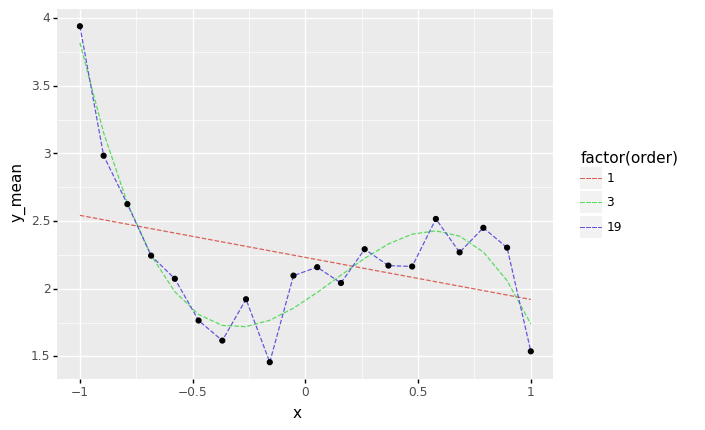

<ggplot: (8744245557797)>

In [13]:
# -- DEMONSTRATION CODE, NO NEED TO EDIT -----
# Fit on many different orders
df_train = pd.DataFrame()
df_test = pd.DataFrame()
for order in range(1, 20):
    # Fit the model
    md_tmp = (
        df_ex3
        >> ft_regression(var=["x"], out=["y"], order=order)
    )
    # Evaluate model on training data
    df_tmp = (
        md_tmp
        >> gr.ev_df(df=df_ex3)
        >> gr.tf_mutate(order=order)
    )
    df_train = pd.concat((df_train, df_tmp), axis=0)
    # Evaluate model on test data
    df_tmp = (
        gr.df_make(x=np.linspace(-1, +1, num=100))
        >> gr.tf_mutate(y=fcn_2(DF.x), order=order)
        >> gr.tf_md(md=md_tmp)
    )
    df_test = pd.concat((df_test, df_tmp), axis=0)

# Visualize a few cases
(
    df_train
    >> gr.tf_filter(gr.var_in(DF.order, [1, 3, 19]))
    >> pt.ggplot(pt.aes("x", "y_mean"))
    + pt.geom_line(pt.aes(color="factor(order)"), linetype="dashed")
    + pt.geom_point(data=df_ex3, mapping=pt.aes(y="y"))
)

Here I've selected just a few of the models to plot. We can see

* The `Order = 1` case is underfit, like we saw in the example above
* The `Order = 19` case curves tortuously to go through _every single point_; this is an example of _overfitting_
* The `Order = 3` case is not perfect, but tends to balance between underfitting and overfitting. This is a well-fit model.

More generally, _overfitting_ is when the model fits to spurrious patterns in the data; essentially, we are fitting to noise, rather than signal. We would like to detect and avoid overfitting in practice! While we can see above some suspicious behavior based on the fitted curves, we might like a _quantitative_ way to compare models. We can do this with the NDE values, but there is a _subtle issue_ at play here.


## Quantifying Error and Cross-Validating

---

TODO Study error quantitatively


In [14]:
## NOTE: No need to edit
(
    df_train
    >> gr.tf_group_by(DF.order)
    >> gr.tf_summarize(
        mse=gr.rmse(DF.y_mean, DF.y),
        ndme=gr.ndme(DF.y_mean, DF.y),
        rsq=gr.rsq(DF.y_mean, DF.y),
    )
)

,order,mse,ndme,rsq
0,1,4.969534e-01,0.934821,0.126109
1,2,4.072525e-01,0.766084,0.413115
2,3,1.648872e-01,0.310170,0.903795
3,4,1.648095e-01,0.310024,0.903885
4,5,1.542671e-01,0.290192,0.915788
5,6,1.454572e-01,0.273620,0.925132
6,7,1.264886e-01,0.237938,0.943385
7,8,1.237756e-01,0.232835,0.945788
8,9,1.233580e-01,0.232049,0.946153
9,10,1.223457e-01,0.230145,0.947033



- `mse` is [mean-squared error](https://en.wikipedia.org/wiki/Mean_squared_error), a common error metric often used in the machine learning community. Smaller values are more accurate.
- `ndme` stands for *non-dimensional model error*. As the name implies, this quantity is dimensionless, and takes a value of `0` when the model is perfect, and a value of `1` (sometimes higher) when the model is uninformative.
- `rsq` is short for $R^2$ (r-squared), also called the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination), a common *goodness of fit* metric used in the statistics community. Higher values are more accurate.


Let's compare the error values `train` on only the available (noisy) data, and the error computed using evaluations from the true (noiseless) function (`test` data).


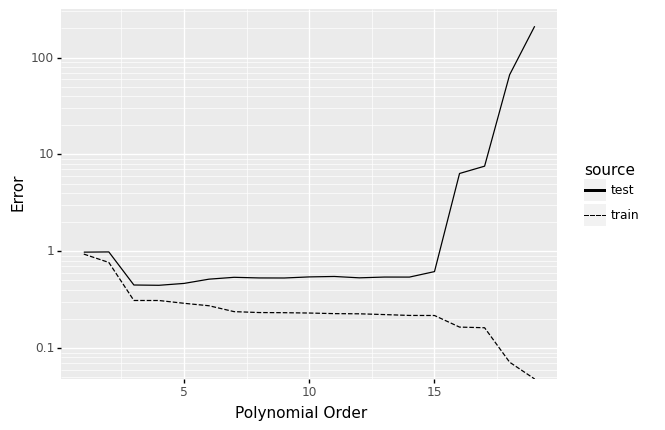

<ggplot: (8744245519415)>

In [15]:
(
    df_train 
    >> gr.tf_mutate(source="train")
    >> gr.tf_bind_rows(
        df_test
        >> gr.tf_mutate(source="test")
    )
    >> gr.tf_group_by(DF.order, DF.source)
    >> gr.tf_summarize(mse=gr.ndme(DF.y_mean, DF.y))
    
    >> pt.ggplot(pt.aes("order", "mse"))
    + pt.geom_line(pt.aes(linetype="source"))
    + pt.scale_y_log10()
    + pt.labs(
        x="Polynomial Order",
        y="Error",
    )
)

Here we can see the `train` and `test` error values _greatly diverge_. This is _highly problematic_ for two interrelated reasons:

1. In practice, we would only have access to the `train` curve, as the `test` curve relies on extra data (that we don't have).
2. If we were to make a decision about `Poly Order` based on the `Estimated` curve, we would choose a much higher order than what would minimize the NDME in the `True` case.

The underlying reason for the poor error estimate here is that _we are using the same data to both train and test the model_. We can improve our estimates for the error through various techniques; below, we will use the technique of _cross-validation_.


### Avoiding Optimistic Estimates: Cross-Validation
[Cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) is a technique for estimating the error in a way that avoids the "optimism" we saw above. For the variant _k-fold cross-validation_, we split all our data into _folds_, and use these to build _training_ and _test_ sets. Generally:

* _Training_ data are used to fit a model
* _Test_ data are used to evaluate a model

![CV schematic](https://upload.wikimedia.org/wikipedia/commons/1/1c/K-fold_cross_validation_EN.jpg)

(Fabian Flock, via Wikimedia)

In each of our $k$ iterations, we _do not allow_ the model to see a test fold (`Test data` above) during training, and fit the model only on the remaining data (`Training data` above). After training, we compute our chosen error metric on the test fold. Finally, we repeat this process on each of the $k$ chosen folds. This gives us a set of less optimistic estimates for the error, which we can summarize e.g. as a mean CV error.

This procedure is implemented in the grama function `tf_kfolds()`, as demonstrated below.


In [16]:
###
# TASK: Use cross_validate() on the 9th order model to estimate the NDE
# TODO: Compute the cross validation scores and assign to `scores`
# Hint, you can pass the helper function `nde_score` (defined above) to cross_validate()
###

# -- WRITE YOUR CODE HERE -----
# solution-begin
(
    df_ex3
    >> gr.tf_kfolds(ft=ft_regression(var=["x"], out=["y"], order=9))
)
# solution-end

# -- NO NEED TO EDIT BELOW -----


... tran_kfolds is using default k=5
... tran_kfolds is using default summaries mse and rsq


,mse_y,rsq_y,_kfold
0,0.085764,0.262905,0
1,0.034198,0.645016,1
2,5.133231,-8.366486,2
3,0.026155,0.483682,3
4,0.969556,-14.717339,4


The `train_score` values are quite optimistic, while the `test_score` values are *abysmal*.

Below, I show results for performing k-fold cross validation across the same set of polynomial orders as above.

... tran_kfolds is using default k=5
... tran_kfolds is using default summaries mse and rsq
... tran_kfolds is using default k=5
... tran_kfolds is using default summaries mse and rsq
... tran_kfolds is using default k=5
... tran_kfolds is using default summaries mse and rsq
... tran_kfolds is using default k=5
... tran_kfolds is using default summaries mse and rsq
... tran_kfolds is using default k=5
... tran_kfolds is using default summaries mse and rsq
... tran_kfolds is using default k=5
... tran_kfolds is using default summaries mse and rsq
... tran_kfolds is using default k=5
... tran_kfolds is using default summaries mse and rsq
... tran_kfolds is using default k=5
... tran_kfolds is using default summaries mse and rsq
... tran_kfolds is using default k=5
... tran_kfolds is using default summaries mse and rsq
... tran_kfolds is using default k=5
... tran_kfolds is using default summaries mse and rsq
... tran_kfolds is using default k=5
... tran_kfolds is using default summaries 

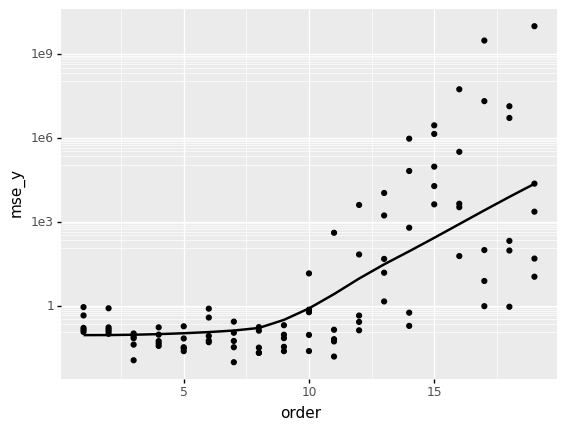

<ggplot: (8744245489448)>

In [17]:
# -- DEMONSTRATION CODE, NO NEED TO EDIT -----
# Fit on many different orders
df_kfolds = pd.DataFrame()
for order in range(1, 20):
    # Evaluate model on test data
    df_tmp = (
        df_ex3
        >> gr.tf_kfolds(ft=ft_regression(var=["x"], out=["y"], order=order))
        >> gr.tf_mutate(order=order)
    )
    df_kfolds = pd.concat((df_kfolds, df_tmp), axis=0)
    
# Visualize
(
    df_kfolds
    >> pt.ggplot(pt.aes("order", "mse_y"))
    + pt.geom_smooth()
    + pt.geom_point()
    + pt.scale_y_log10()
)


The individual CV estimates are reported as dots, while their mean is given as a line. Here we can see that the NDE takes reasonable values for order at or below `3`. Beyond this point, the NDE explodes as models begin to overfit wildly. These cross-validated error metrics would be far more informative for making a decision about polynomial order.

Here we have just one tunable knob (polynomial order) that defines our model. More generally, these kinds of user-selected quantities are called [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)). Cross-validation and related techniques are key to _tuning hyperparameters_.

### Using Models for Materials Informatics
In the final part of the workshop, we will discuss how to _use_ these machine learning models to do useful work in materials science. Stay tuned!